### Variables

- **InvoiceNo**: Invoice number. Unique number for each transaction; transactions starting with 'C' indicate canceled transactions.

- **StockCode**: Product code. Unique number for each product.

- **Description**: Product name.

- **Quantity**: Quantity of products. Indicates how many of each product were sold in the transactions.

- **InvoiceDate**: Invoice date and time.

- **UnitPrice**: Product price (in Sterling).

- **CustomerID**: Unique customer number.

- **Country**: Country name. The country where the customer resides.

# STEP-1: Data Understanding

In [1]:
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('Year-2009-2010.csv', encoding='latin-1')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.250,13085.000,United Kingdom


In [4]:
from ydata_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.000,10.338,107.424,-9600.000,1.000,3.000,10.000,19152.000
Price,525461.000,4.689,146.127,-53594.360,1.250,2.100,4.210,25111.090
Customer ID,417534.000,15360.645,1680.811,12346.000,13983.000,15311.000,16799.000,18287.000


In [7]:
df["Description"].nunique()

4681

In [8]:
df["Description"].value_counts().head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    3549
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
Name: count, dtype: int64

In [9]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.groupby("Invoice").agg({"TotalPrice": "sum"}).head()

,TotalPrice
Invoice,
489434,505.300
489435,145.800
489436,630.330
489437,310.750
489438,2286.240


# STEP-2: Data Preparation

In [10]:
df.dropna(inplace=True)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.000,12.759,101.220,-9360.000,2.000,4.000,12.000,19152.000
Price,417534.000,3.888,71.132,0.000,1.250,1.950,3.750,25111.090
Customer ID,417534.000,15360.645,1680.811,12346.000,13983.000,15311.000,16799.000,18287.000
TotalPrice,417534.000,19.994,99.916,-25111.090,4.250,11.250,19.350,15818.400


In [12]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

In [13]:
# Performing refund transactions on invoices
df = df[~df["Invoice"].str.contains("C", na=False)] 
df[df["Invoice"].str.contains("C", na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice


In [14]:
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
df["InvoiceDate"].head()

0    2009-12-01 07:45:00
1    2009-12-01 07:45:00
2    2009-12-01 07:45:00
3    2009-12-01 07:45:00
4    2009-12-01 07:45:00
Name: InvoiceDate, dtype: object

# STEP-3: RFM

In [16]:
today_date = dt.datetime(2024, 7, 17)

In [17]:
rfm = df.groupby(['Customer ID',"Country"]).agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,'Invoice': lambda Invoice: Invoice.nunique(),'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
rfm.head()

,,InvoiceDate,Invoice,TotalPrice
Customer ID,Country,,,
12346.000,United Kingdom,5132,11,372.860
12347.000,Iceland,4970,2,1323.320
12348.000,Finland,5041,1,222.160
12349.000,Italy,5010,3,2671.140
12351.000,Unspecified,4978,1,300.930


## InvoiceDate

InvoiceDate indicates the time elapsed since the customer's last purchase. It signifies how recently the customer was serviced or engaged with. Recency scores are determined in customer segmentation and play a significant role in future sales forecasts.

## Price

Price represents the total amount spent by the customer. It is used to determine customer value and strengthen future sales forecasts.

## Invoice

Invoice is a unique number that identifies each sales transaction individually. It is used for tracking customer purchases and transactions. Invoice data is crucial in customer segmentation and sales reporting.

In [18]:
rfm.columns = ["recency", "frequency", "monetary"]

In [19]:
# Customers with a monetary value of zero or negative are excluded in RFM analysis.
# Therefore, we select customers with a positive monetary value from the dataset.
rfm = rfm[rfm["monetary"] > 0]
rfm.shape

(4317, 3)

In [20]:
rfm["recency_score"] = pd.qcut(rfm["recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm.head()

,,recency,frequency,monetary,recency_score,monetary_score,frequency_score
Customer ID,Country,,,,,,
12346.000,United Kingdom,5132,11,372.860,2,2,5
12347.000,Iceland,4970,2,1323.320,5,4,2
12348.000,Finland,5041,1,222.160,2,1,1
12349.000,Italy,5010,3,2671.140,3,5,3
12351.000,Unspecified,4978,1,300.930,5,2,1


In [21]:
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))
rfm.head()

,,recency,frequency,monetary,recency_score,monetary_score,frequency_score,RFM_SCORE
Customer ID,Country,,,,,,,
12346.000,United Kingdom,5132,11,372.860,2,2,5,25
12347.000,Iceland,4970,2,1323.320,5,4,2,52
12348.000,Finland,5041,1,222.160,2,1,1,21
12349.000,Italy,5010,3,2671.140,3,5,3,33
12351.000,Unspecified,4978,1,300.930,5,2,1,51


In [22]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [23]:
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,Customer ID,Country,recency,frequency,monetary,recency_score,monetary_score,frequency_score,RFM_SCORE,segment
0,12346.000,United Kingdom,5132,11,372.860,2,2,5,25,cant_loose
1,12347.000,Iceland,4970,2,1323.320,5,4,2,52,potential_loyalists
2,12348.000,Finland,5041,1,222.160,2,1,1,21,hibernating
3,12349.000,Italy,5010,3,2671.140,3,5,3,33,need_attention
4,12351.000,Unspecified,4978,1,300.930,5,2,1,51,new_customers


- **hibernating:** Customers who have not shopped recently and have low spending.
  
- **at_Risk:** Customers who have not shopped recently but have high spending in the past.
  
- **cant_loose:** Customers who have not shopped recently but have high spending, making them very valuable.
  
- **about_to_sleep:** Customers who have shopped infrequently and have low spending.
  
- **need_attention:** Customers who shop moderately but may be lost if not engaged with.
  
- **loyal_customers:** Customers who shop regularly and spend a lot.
  
- **promising:** Customers who have shopped recently and have the potential to be valuable.
  
- **new_customers:** Customers who have recently made their first purchase.
  
- **potential_loyalists:** Customers who have shopped recently and have the potential to become loyal.
  
- **champions:** Customers who are the most valuable, having shopped most recently, frequently, and spent the most.

In [24]:
rfm.groupby('segment').agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

,Customer ID
segment,
hibernating,1018
loyal_customers,743
champions,663
at_Risk,611
potential_loyalists,516
about_to_sleep,344
need_attention,207
promising,88
cant_loose,77


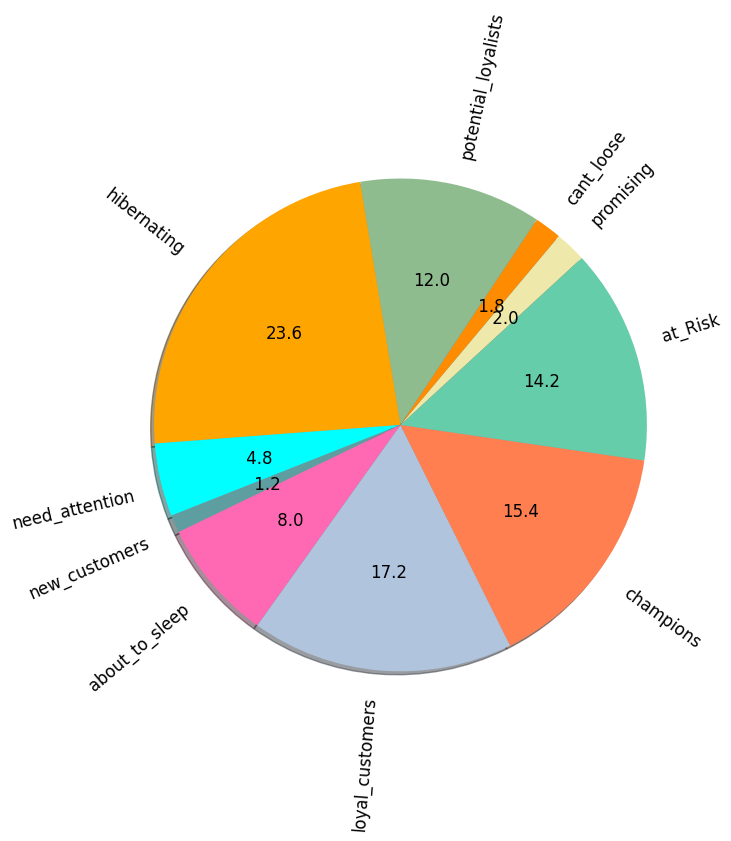

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
colors  = ("darkorange", "darkseagreen", "orange", "cyan", "cadetblue", "hotpink", "lightsteelblue", "coral",  "mediumaquamarine","palegoldenrod")
explodes = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(6,4)) 
rfm["segment"].value_counts(sort=False).plot.pie(colors=colors,
                                                 textprops={'fontsize': 12}, 
                                                 autopct = '%4.1f',
                                                 startangle= 50, 
                                                 radius =2, 
                                                 rotatelabels=True,
                                                 shadow = True, 
                                                 explode = explodes)
plt.ylabel("")
plt.show()

In [26]:
from math import pi
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

output_notebook()

segments = [
    'about_to_sleep', 'at_Risk', 'cant_loose',
    'champions', 'hibernating', 'loyal_customers',
    'need_attention', 'new_customers', 'potential_loyalists', 'promising'
]

counts = rfm['segment'].value_counts()[segments]
colors = ("darkorange", "darkseagreen", "orange", "cyan", "cadetblue", "hotpink", "lightsteelblue", "coral", "mediumaquamarine", "palegoldenrod")
cumulative_angles = [0] + [2 * pi * sum(counts[:i + 1]) / sum(counts) for i in range(len(counts))]

source = ColumnDataSource(data=dict(
    segments=segments,
    counts=counts,
    start_angle=cumulative_angles[:-1],
    end_angle=cumulative_angles[1:],
    colors=colors,
))

p = figure(title="RFM Segment Distribution", toolbar_location=None,
           tools="hover", tooltips=[("Segment", "@segments"), ("Count", "@counts")],
           x_range=(-1.2, 1.2), y_range=(-1.2, 1.2))

p.wedge(x=0, y=0, radius=1,
        start_angle='start_angle', end_angle='end_angle',
        fill_color='colors', line_color="white", legend_field='segments', source=source)

p.axis.visible = False

show(p)

Loading BokehJS ...

In [27]:
rfm[["recency", "frequency", "monetary"]].agg(["mean"])

,recency,frequency,monetary
mean,5058.228,4.451,2045.866


In [28]:
rfm[["segment","recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count","sum"])

recency                frequency             monetary  \
                        mean count      sum      mean count   sum     mean   
segment                                                                      
about_to_sleep      5020.866   344  1727178     1.201   344   413  440.624   
at_Risk             5119.195   611  3127828     3.075   611  1879 1190.244   
cant_loose          5091.117    77   392016     9.117    77   702 4099.450   
champions           4974.119   663  3297841    12.548   663  8319 6849.610   
hibernating         5180.787  1018  5274041     1.127  1018  1147  403.990   
loyal_customers     5003.320   743  3717467     6.820   743  5067 2742.099   
need_attention      5020.266   207  1039195     2.449   207   507 1060.357   
new_customers       4975.580    50   248779     1.000    50    50  386.199   
potential_loyalists 4985.785   516  2572665     2.017   516  1041  729.446   
promising           4992.716    88   439359     1.000    88    88  368.191   

                                       
                    count         sum  
segment                                
about_to_sleep        344  151574.820  
at_Risk               611  727238.891  
cant_loose             77  315657.650  
champions             663 4541291.493  
hibernating          1018  411261.714  
loyal_customers       743 2037379.916  
need_attention        207  219493.900  
new_customers          50   19309.960  
potential_loyalists   516  376394.100  
promising              88   32400.830

Now, let's focus on some segments which can be critically important for marketing strategies

* champions
* loyal_customers
* need_attention
* cant_loose 

### Champions:
- This segment constitutes 15% of the customer portfolio and includes 663 customers who made their last purchases within the past week.
- On average, these 663 customers have made 12.548 purchases and generated a total monetary value of 4,541,291.49 TL.
- This segment consists of customers who spend the most and easily adapt to new products and services, making cross-selling strategies applicable.

### Loyal Customers:
- There are 743 customers in this segment. While the average purchase frequency across all customer segments is 4, in this segment, it is 6,820.
- The average monetary value of this segment is 50% higher than the general average.
- Cross-selling communications tailored to customer expectations and needs can sustain customer loyalty.

### Need Attention:
- This segment comprises 207 customers whose last purchases were almost 2 months ago.
- Although these customers do not purchase frequently, their total transaction amounts contribute significantly to profitability.
- Cashback and bonus campaigns can be organized to retain these customers and transition them to a segment that makes more purchases. Additionally, campaigns based on discounted product offers and gift coupons can be planned by observing similar behaviors and analyzing product association rules.

### Can't Lose:
- Customers in the Can't Lose segment have a higher transaction frequency, even though their spending amounts are close to the loyal customer segment.
- However, since these customers made their last purchases almost 4 months ago, new campaign strategies based on rewards, discounts, and other special incentives can be planned to attract and retain them, making them feel special and loyal again.

# Step 4: Data Analysis

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [30]:
X = rfm[['monetary', 'recency', 'frequency']]  
y = rfm['monetary']  

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [34]:
y_pred = model.predict(X_test_scaled)

In [35]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Squared Error (MSE): 889536.94
Mean Absolute Error (MAE): 83.23


In [36]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

# This figure shows the relationship between actual sales values and forecasted sales values.
source_scatter = ColumnDataSource(data=dict(
    Actual=y_test,
    Predicted=y_pred,
    Monetary=X_test['monetary'],  
    Recency=X_test['recency'],
    Frequency=X_test['frequency']
))

scatter = figure(title='Actual vs Predicted Sales',
                 x_axis_label='Actual Sales',
                 y_axis_label='Predicted Sales',
                 height=400, width=600)

scatter.scatter('Actual', 'Predicted', size=8, source=source_scatter, color='blue', alpha=0.6)
scatter.line([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], line_color='red', line_dash='dashed')

show(scatter)

Loading BokehJS ...

In [37]:
# The degree of importance of each feature in the model.
features = X.columns.tolist()  
importance = model.feature_importances_

source_bar = ColumnDataSource(data=dict(
    Features=features,
    Importance=importance
))

bar = figure(title='Feature Importance',
             x_axis_label='Features',
             y_axis_label='Importance',
             x_range=features, 
             height=400, width=600)

bar.vbar(x='Features', top='Importance', width=0.5, color='skyblue', source=source_bar)
bar.xaxis.major_label_orientation = 1.2 
show(bar)

## Factors Affecting Sales

The analysis of the feature importance graph reveals the following insights:

### 1. Monetary
- **Importance:** The most influential feature.
- **Value:** Almost above 0.9.
- **Interpretation:** This indicates that the monetary value is the most critical factor in the model or analysis, significantly impacting sales.

### 2. Frequency
- **Importance:** The second most important feature.
- **Value:** Approximately between 0.1 and 0.2.
- **Interpretation:** Although not as influential as the monetary value, frequency plays a significant role in the analysis, affecting sales considerably.

### 3. Recency
- **Importance:** The least important feature.
- **Value:** Around 0.05.
- **Interpretation:** This suggests that recency has a much lower impact on sales compared to the other two features.

Overall, the monetary value is the primary determinant of sales, followed by frequency, with recency being the least influential.